# Eccenticity plots


✅ Saved Polar Plot with Custom Settings to: C:\Users\RReddy\Downloads\eccentricity_polar_custom.pdf


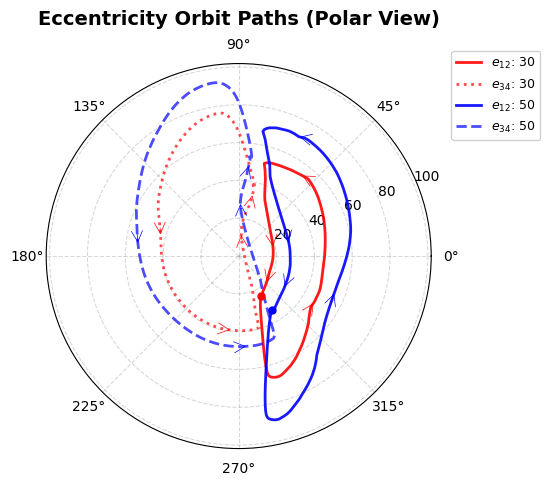

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# --- Utility Functions (Kept as is) ---
def get_revolution_data(file_path):
    """
    Reads a simulation file, finds the angle column, and extracts 
    the data corresponding to the last full revolution.
    """
    if not os.path.isfile(file_path):
        print(f"⚠️ File not found: {file_path}")
        return None

    try:
        # Read file (handles flexible separators)
        df = pd.read_csv(file_path, sep=None, engine="python", comment='#')
    except Exception as e:
        print(f"⚠️ Error reading {file_path}: {e}")
        return None

    # Check for required columns
    required_cols = {'e_1', 'e_2', 'e_3', 'e_4'}
    if not required_cols.issubset(df.columns):
        print(f"⚠️ Missing columns {required_cols} in {os.path.basename(file_path)}")
        return None

    # Identify Angle Column
    angle_candidates = ['phi', 'angle', 'shaft_angle', 'theta', 'crank_angle']
    angle_col = next((col for col in angle_candidates if col in df.columns), None)

    if not angle_col:
        print(f"⚠️ No angle column found in {os.path.basename(file_path)}")
        return None

    # Detect Unit (Degrees vs Radians)
    angles_full = df[angle_col].to_numpy()
    is_degrees = angles_full.max() > 15
    
    # Logic to find the last complete revolution
    diffs = np.diff(angles_full)
    threshold = -180 if is_degrees else -3.0
    wraparounds = np.where(diffs < threshold)[0]

    if len(wraparounds) >= 1:
        start_idx = wraparounds[-1] + 1
        if len(wraparounds) >= 2:
            start_idx = wraparounds[-2] + 1
            end_idx = wraparounds[-1] + 1
        else:
            end_idx = len(df)
    else:
        # Fallback: Take last 360 points
        start_idx = max(0, len(df) - 361)
        end_idx = len(df)

    df_rev = df.iloc[start_idx:end_idx].reset_index(drop=True)
    
    if len(df_rev) < 5:
        return None

    return df_rev, is_degrees


def cartesian_to_polar(x, y):
    """Converts Cartesian (x,y) to Polar (radius, theta)."""
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

# --- Fixed Arrow Function ---
def add_polar_arrow(ax, theta_arr, r_arr, color, arrow_lw):
    """
    Adds directional arrows along a polar path.
    FIXED: Removed 'head_width' and 'head_length' which caused the AttributeError.
    """
    n_points = len(theta_arr)
    # Place 4 arrows evenly spaced along the path
    indices = [int(n_points * 0.2), int(n_points * 0.45), int(n_points * 0.7), int(n_points * 0.9)]
    
    for i in indices:
        # Ensure there are enough points ahead to define a direction
        if i >= n_points - 5: continue
        
        # Start and End points for the arrow segment
        t_start, r_start = theta_arr[i], r_arr[i]
        look_ahead = min(i + 5, n_points - 1)
        t_end, r_end = theta_arr[look_ahead], r_arr[look_ahead]

        # Annotate draws an arrow from xytext (tail) to xy (head)
        ax.annotate(
            '', 
            xy=(t_end, r_end),        # Arrow Head position (theta, r)
            xytext=(t_start, r_start),  # Arrow Tail position (theta, r)
            arrowprops=dict(
                arrowstyle='->', 
                color=color, 
                lw=arrow_lw, 
                shrinkA=0, shrinkB=0,
                mutation_scale=20 # Scale the arrowhead size based on line width
            )
        )


def plot_polar_eccentricities(file_paths, labels=None, convert_to_microns=True,
                              plot_size=(8, 8),
                              line_width=2.0,
                              marker_size=6,
                              arrow_line_width=2.0,
                              legend_loc='upper right',
                              legend_bbox=(1.3, 1.1)):
    """
    Plots eccentricity paths on a Polar Graph with Arrows.
    """
    
    if not file_paths:
        print("⚠️ No files provided.")
        return

    if labels is None:
        labels = [f"Case {i+1}" for i in range(len(file_paths))]

    # Setup Polar Plot with adjustable size
    fig, ax = plt.subplots(figsize=plot_size, subplot_kw={'projection': 'polar'})

    colors = ['red', 'blue', 'black', 'green', 'orange', 'purple']
    line_styles_e12 = ['-', '-', '-', '-', '-', '-']  
    line_styles_e34 = [':', '--', ':', '--', ':', '--'] 

    max_radius = 0 

    for idx, file_path in enumerate(file_paths):
        result = get_revolution_data(file_path)
        if result is None:
            continue
            
        df, _ = result
        
        # 1. Extract Data and Convert to Microns
        x12, y12 = df['e_1'].to_numpy(), df['e_2'].to_numpy()
        x34, y34 = df['e_3'].to_numpy(), df['e_4'].to_numpy()

        if convert_to_microns:
            x12, y12 = x12 * 1e6, y12 * 1e6
            x34, y34 = x34 * 1e6, y34 * 1e6

        # 2. Close the loop and Convert to Polar
        x12_closed = np.append(x12, x12[0])
        y12_closed = np.append(y12, y12[0])
        x34_closed = np.append(x34, x34[0])
        y34_closed = np.append(y34, y34[0])

        r12, theta12 = cartesian_to_polar(x12_closed, y12_closed)
        r34, theta34 = cartesian_to_polar(x34_closed, y34_closed)

        current_max = max(np.max(r12), np.max(r34))
        if current_max > max_radius:
            max_radius = current_max

        # 3. Plotting
        label_txt = labels[idx] if idx < len(labels) else f"Case {idx+1}"
        color = colors[idx % len(colors)]

        # Plot e12
        ax.plot(theta12, r12, 
                linestyle=line_styles_e12[idx % len(line_styles_e12)],
                linewidth=line_width, color=color, alpha=0.9,
                label=f"$e_{{12}}$: {label_txt}")
        
        # Add Arrows to e12
        add_polar_arrow(ax, theta12[:-1], r12[:-1], color, arrow_line_width) 
        
        # Plot e34
        ax.plot(theta34, r34, 
                linestyle=line_styles_e34[idx % len(line_styles_e34)],
                linewidth=line_width, color=color, alpha=0.7,
                label=f"$e_{{34}}$: {label_txt}")
        
        # Add Arrows to e34
        add_polar_arrow(ax, theta34[:-1], r34[:-1], color, arrow_line_width)

        # --- Start Markers (Filled circles) ---
        # e12 start marker
        r12_start, theta12_start = r12[0], theta12[0]
        ax.plot(theta12_start, r12_start, 'o', color=color, markersize=marker_size, zorder=5)
        
        # e34 start marker (NEW)
        r34_start, theta34_start = r34[0], theta34[0]
        ax.plot(theta34_start, r34_start, 'o', color=color, markersize=marker_size, zorder=5)

        # --- Midpoint Markers (Hollow circles at 180°/half revolution) ---
        # Find midpoint index (approximately halfway through the data)
        mid_idx = len(r12) // 2
        
        # e12 midpoint marker (hollow)
        r12_mid, theta12_mid = r12[mid_idx], theta12[mid_idx]
        ax.plot(theta12_mid, r12_mid, 'o', color=color, markersize=marker_size, 
                markerfacecolor='none', markeredgewidth=1.5, zorder=5)
        
        # e34 midpoint marker (hollow)
        r34_mid, theta34_mid = r34[mid_idx], theta34[mid_idx]
        ax.plot(theta34_mid, r34_mid, 'o', color=color, markersize=marker_size, 
                markerfacecolor='none', markeredgewidth=1.5, zorder=5)

    # --- Chart Cosmetics ---
    ax.set_theta_zero_location("E") 
    ax.set_theta_direction(1)
    ax.set_ylim(0, max_radius * 1.1)
    ax.grid(True, alpha=0.3, color='gray', linestyle='--')
    
    # Legend - Placement now adjustable
    ax.legend(loc=legend_loc, bbox_to_anchor=legend_bbox, fontsize=9, framealpha=0.9)
    
    plt.title("Eccentricity Orbit Paths (Polar View)", y=1.08, fontsize=14, fontweight='bold')

    # Save
    downloads = os.path.join(os.path.expanduser("~"), "Downloads")
    os.makedirs(downloads, exist_ok=True)
    out_pdf = os.path.join(downloads, "eccentricity_polar_custom.pdf")
    
    with PdfPages(out_pdf) as pdf:
        pdf.savefig(fig, bbox_inches='tight')
    
    print(f"\n✅ Saved Polar Plot with Custom Settings to: {out_pdf}")
    plt.show()

# -------------------------
# Execution Block
# -------------------------
if __name__ == "__main__":
    
    # Define your files here
    base_path = r"X:\Reddy\Caspar\V30G-205"
    
    # Example Paths (Update as needed)
    file_list = [
        
         r"X:\Reddy\Caspar\V30G-205\Hengli Designs\Clearance_study_with_micro_surface\T60_2850rpm_350bar_100d_30\output\piston\piston.txt",

        
         r"X:\Reddy\Caspar\V30G-205\Hengli Designs\Clearance_study_with_micro_surface\T60_2850rpm_350bar_100d_50\output\piston\piston.txt",
    ]

    my_labels = [

        "30",
        "50"
    ]
            
        
    
    # --- Custom Plot Settings ---
    custom_plot_size = (5, 5)
    custom_line_width = 2.0
    custom_marker_size = 5
    custom_arrow_lw = 0.5 # Line width for the arrows
    # Legend location
    custom_legend_loc = 'upper right'
    custom_legend_bbox = (1.3, 1.05) 

    plot_polar_eccentricities(
        file_paths=file_list, 
        labels=my_labels,
        plot_size=custom_plot_size,
        line_width=custom_line_width,
        marker_size=custom_marker_size,
        arrow_line_width=custom_arrow_lw,
        legend_loc=custom_legend_loc,
        legend_bbox=custom_legend_bbox
    )